<a href="https://colab.research.google.com/github/vjuge/oc-iml/blob/P6/modules/P6/module_P6_V3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [27]:
import tensorflow as tf
import tensorflow_datasets as tfds
from keras.utils.vis_utils import plot_model
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageShow
import cv2 as cv
import sklearn

import tensorflow as tf
from tensorflow import keras
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.utils.vis_utils import plot_model
from keras import backend as K
from keras.models import load_model
from tensorflow.keras import layers

from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"


In [28]:
device_name = tf.test.gpu_device_name()
if "GPU" not in device_name:
    print("GPU device not found")
else: print('Found GPU at: {}'.format(device_name))

GPU device not found


## Download Dataset

In [29]:
# tfds.disable_progress_bar()

(train_ds, test_ds), ds_info = tfds.load(
    "stanford_dogs",
    split=['train', 'test'],
    as_supervised=True,
    with_info=True
)

In [30]:
NO_BREEDS = ds_info.features['label'].num_classes

In [31]:
ds_info.features['label']
ds_info.features['label'].names[:20]

ClassLabel(shape=(), dtype=tf.int64, num_classes=120)

['n02085620-chihuahua',
 'n02085782-japanese_spaniel',
 'n02085936-maltese_dog',
 'n02086079-pekinese',
 'n02086240-shih-tzu',
 'n02086646-blenheim_spaniel',
 'n02086910-papillon',
 'n02087046-toy_terrier',
 'n02087394-rhodesian_ridgeback',
 'n02088094-afghan_hound',
 'n02088238-basset',
 'n02088364-beagle',
 'n02088466-bloodhound',
 'n02088632-bluetick',
 'n02089078-black-and-tan_coonhound',
 'n02089867-walker_hound',
 'n02089973-english_foxhound',
 'n02090379-redbone',
 'n02090622-borzoi',
 'n02090721-irish_wolfhound']

In [32]:
ds_info.features

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=tf.uint8),
    'image/filename': Text(shape=(), dtype=tf.string),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=120),
    'objects': Sequence({
        'bbox': BBoxFeature(shape=(4,), dtype=tf.float32),
    }),
})

## Dataset preprocessing

1. On applique un resizing des images afin d'avoir un dataset consistant.

> note: on peut resizer à 150 x 150, car si on garde 299 x 299 (default XCeption), la ram est tout juste suffisante sur collab, le fitting peut planter :

```
Votre session a planté après avoir utilisé toute la RAM disponible.

En tant qu'abonné Colab Pro, vous disposez de plus de mémoire, mais si vous êtes intéressé par des environnements d'exécution à mémoire RAM encore plus élevée, envisagez de passer à Colab Pro+.
```


2. On applique aussi un One Hot sur les labels

In [33]:
IMG_SIZE = 299
size = (IMG_SIZE, IMG_SIZE)


In [34]:

train_ds = train_ds\
    .map(lambda x, y: (tf.image.resize(x, size), y))\
    .map(lambda x, y: (x, tf.one_hot(y, depth=NO_BREEDS))) # transform labels to one hot encoding


test_ds = test_ds\
    .map(lambda x, y: (tf.image.resize(x, size), y))\
    .map(lambda x, y: (x, tf.one_hot(y, depth=NO_BREEDS))) #depth is number of classes


On applique un batching et un prefetch sur les datasets, cela va permettre de préparer et optimiser les dataset en vue de faire le fitting

In [35]:
batch_size = 32

train_ds = train_ds.cache().batch(batch_size).prefetch(buffer_size=10)
test_ds = test_ds.cache().batch(batch_size).prefetch(buffer_size=10)

On applique une étape de data augmentation au dataset.
En effet, on ne dispose pas de beaucoup de samples, en appliquant des transformations aléatoires on augmente le nombre de samples.

On choisi d'appliquer deux transformations:
* mirroir horizontal (inverse la droite et la gauche)
* rotation (10% à droite ou à gauche)

In [36]:
from tensorflow import keras
from tensorflow.keras import layers

data_augmentation = keras.Sequential(
    [layers.RandomFlip("horizontal"), layers.RandomRotation(0.1),]
)

Exemple d'image du dataset après data augmentation :

<Figure size 720x720 with 0 Axes>

(-0.5, 298.5, 298.5, -0.5)

(-0.5, 298.5, 298.5, -0.5)

(-0.5, 298.5, 298.5, -0.5)

(-0.5, 298.5, 298.5, -0.5)

(-0.5, 298.5, 298.5, -0.5)

(-0.5, 298.5, 298.5, -0.5)

(-0.5, 298.5, 298.5, -0.5)

(-0.5, 298.5, 298.5, -0.5)

(-0.5, 298.5, 298.5, -0.5)

2022-06-29 15:01:08.364925: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


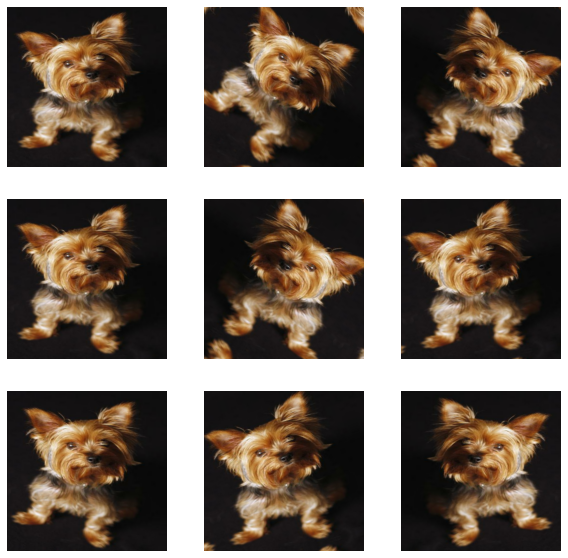

In [37]:
import numpy as np

for images, labels in train_ds.take(1):
    plt.figure(figsize=(10, 10))
    first_image = images[0]
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        augmented_image = data_augmentation(
            tf.expand_dims(first_image, 0), training=True
        )
        plt.imshow(augmented_image[0].numpy().astype("int32"))
        # plt.title(int(labels[0]))
        plt.axis("off")

In [38]:
# Function to display loss and accuracy graphs

def plot_history_scores(dict_history, first_score, second_score):
    with plt.style.context('seaborn-whitegrid'):
        fig = plt.figure(figsize=(25,10))
        # summarize history for accuracy
        plt.subplot(1, 2, 1)
        plt.plot(dict_history.history[first_score], color="g")
        plt.plot(dict_history.history['val_' + first_score],
                 linestyle='--', color="orange")
        plt.title('CNN model ' + first_score, fontsize=18)
        plt.ylabel(first_score)
        plt.xlabel('epoch')
        plt.legend(['train', 'validation'], loc='upper left')
        # summarize history for loss
        plt.subplot(1, 2, 2)
        plt.plot(dict_history.history[second_score], color="g")
        plt.plot(dict_history.history['val_' + second_score],
                 linestyle='--', color="orange")
        plt.title('CNN model ' + second_score, fontsize=18)
        plt.ylabel(second_score)
        plt.xlabel('epoch')
        plt.legend(['train', 'validation'], loc='upper left')
        plt.show()

## Model from Scratch

On va créer un modèle simple, non pre-entrainé

On utilise l'api Sequential de keras

In [39]:
model_scratch = Sequential([
    layers.InputLayer(input_shape=(IMG_SIZE, IMG_SIZE, 3)),
#   layers.Resizing(IMG_SIZE, IMG_SIZE, crop_to_aspect_ratio=True),
  layers.Rescaling(1./255),
#   layers.Reshape((IMG_SIZE, IMG_SIZE, 3)),
  
  # Convolution layer
  layers.Conv2D(filters=16,
                kernel_size=(3,3), 
                padding='same', 
                activation='relu'),
  layers.BatchNormalization(axis=3, scale=False),
  layers.Activation('relu'),

  # Pooling layer
  layers.MaxPooling2D(pool_size=(4,4),
                      strides=(4,4),
                    padding='same'),
  # Second convolution layer
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.BatchNormalization(axis=3, scale=False),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),   #add dropout for better performances

  # Third convolution layer
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.BatchNormalization(axis=3, scale=False),
  layers.GlobalAveragePooling2D(),
  
  # Fully connected layers
  layers.Dense(128, activation='relu'),
  layers.Dense(NO_BREEDS, activation='softmax')
])


In [40]:
model_scratch.compile(
    optimizer=keras.optimizers.Adam(),
    loss=keras.losses.CategoricalCrossentropy(),
    metrics=[keras.metrics.CategoricalAccuracy(), tf.keras.metrics.Precision(), tf.keras.metrics.Recall()],
)

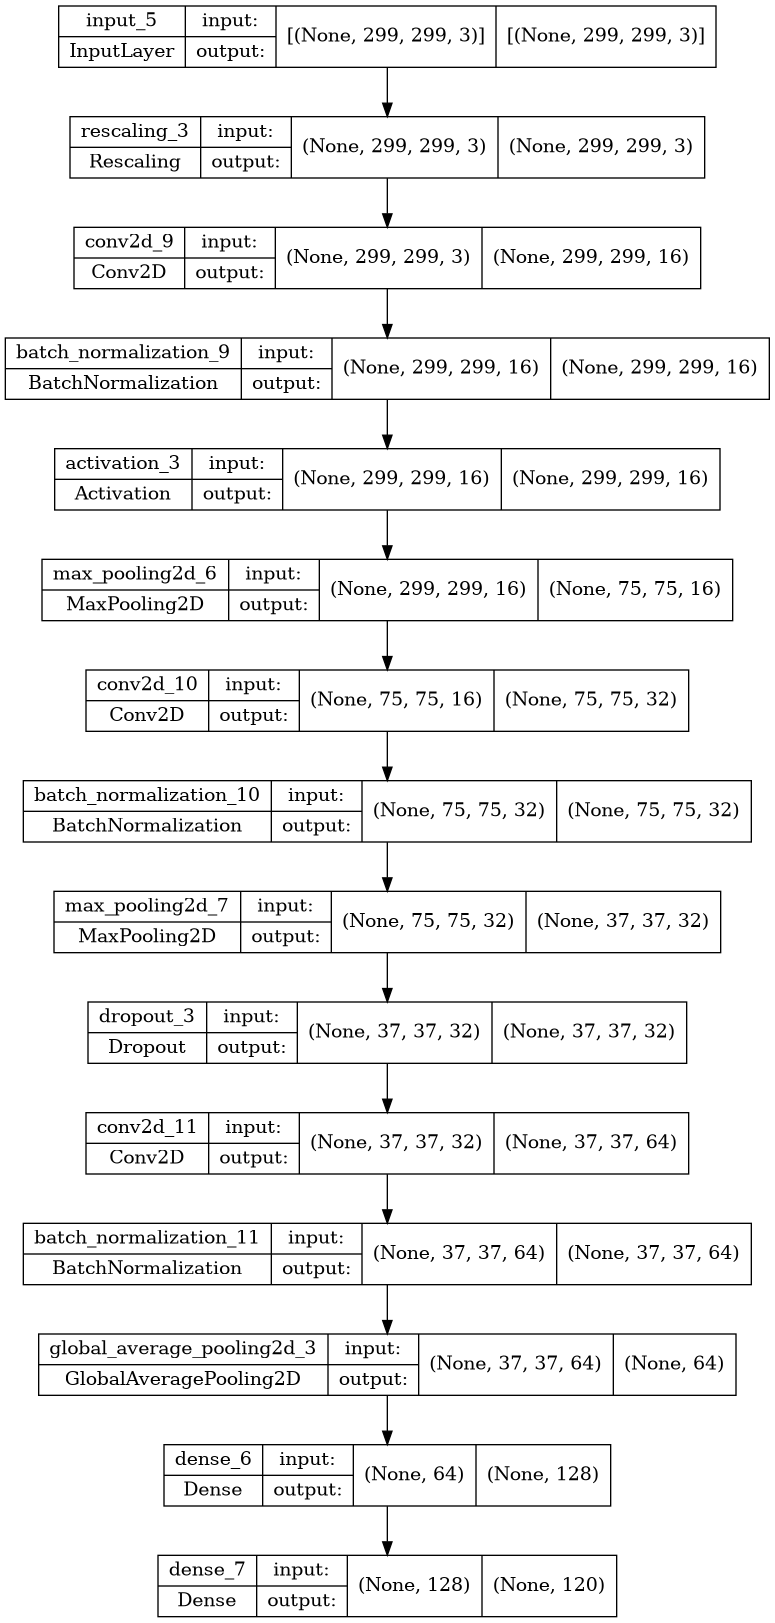

In [41]:
plot_model(model_scratch, show_shapes=True, show_layer_names=True, to_file='model_dummy.png')

In [42]:
epochs = 600
history_scratch = model_scratch.fit(train_ds, epochs=epochs, validation_data=test_ds)

Epoch 1/600
375/375 [==============================] - 229s 610ms/step - loss: 4.7210 - categorical_accuracy: 0.0194 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 5.0635 - val_categorical_accuracy: 0.0147 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/600
375/375 [==============================] - 234s 624ms/step - loss: 4.5047 - categorical_accuracy: 0.0373 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 4.6434 - val_categorical_accuracy: 0.0249 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/600
375/375 [==============================] - 230s 612ms/step - loss: 4.3377 - categorical_accuracy: 0.0503 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 9.3095 - val_categorical_accuracy: 0.0121 - val_precision: 0.0107 - val_recall: 0.0010
Epoch 4/600
375/375 [==============================] - 231s 615ms/step - loss: 4.2038 - categorical_accuracy: 0.0669 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 4.3988 - val_categorical_ac

KeyboardInterrupt: 

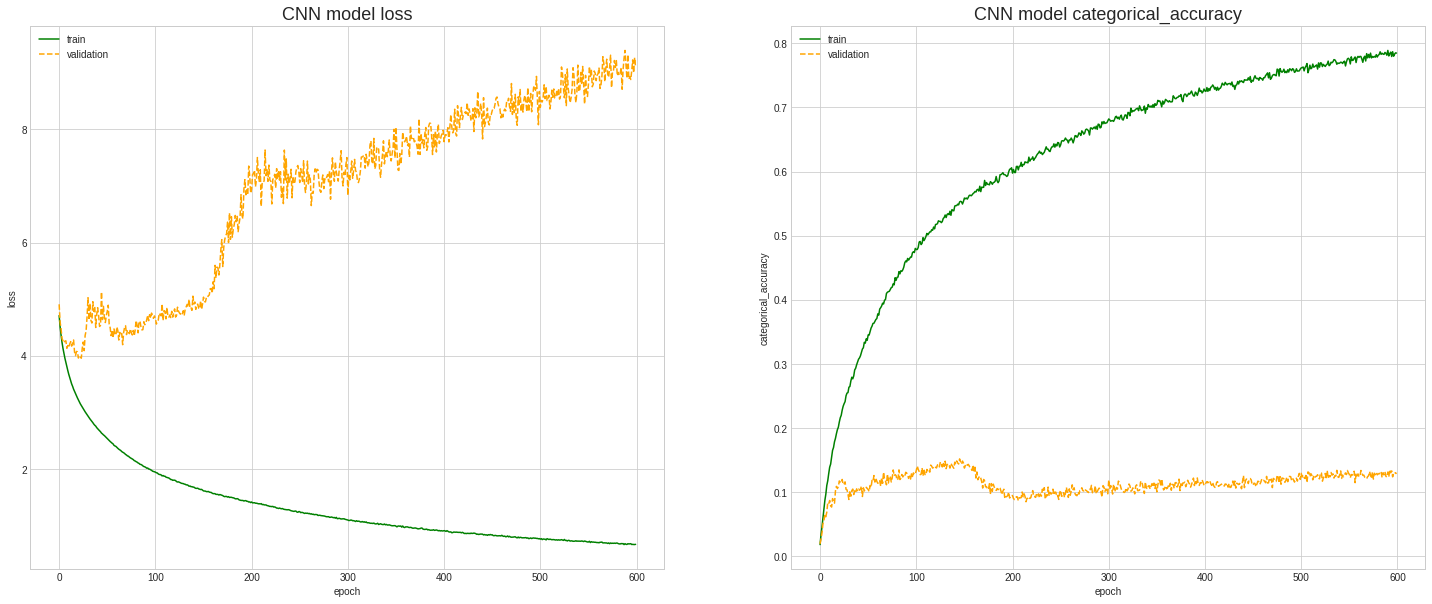

In [17]:
plot_history_scores(history_scratch, "loss", "categorical_accuracy")

On voit qu'après 600 epochs, qui représente + 3h de compute, accuracy continue de progresser. Mais on est clairement dans de l'overfitting, car le validation loss continue de progresser, alors que le training loss continue de baisse.

Par contre on risquerait de faire de l'over fitting. Pour éviter cela, en plus de la couche de dropout, et de la data augmentation, on peut ajouter de la regularisation.


explication tensorflow: <https://www.tensorflow.org/tutorials/keras/overfit_and_underfit>

explication underfitting / overfitting : <https://www.baeldung.com/cs/training-validation-loss-deep-learning>




In [25]:
history_scratch.model.save('scratch_trained_model.h5')

## Xception model

In [18]:
base_model = keras.applications.Xception(
    weights="imagenet",  # Load weights pre-trained on ImageNet.
    input_shape=(299, 299, 3),
    include_top=False,
)  # Do not include the ImageNet classifier at the top.

# Freeze the base_model
base_model.trainable = False

# Create new model on top
inputs = keras.Input(shape=(299, 299, 3))
x = data_augmentation(inputs)  # Apply random data augmentation

# Pre-trained Xception weights requires that input be scaled
# from (0, 255) to a range of (-1., +1.), the rescaling layer
# outputs: `(inputs * scale) + offset`
scale_layer = keras.layers.Rescaling(scale=1 / 127.5, offset=-1)
x = scale_layer(x)

# The base model contains batchnorm layers. We want to keep them in inference mode
# when we unfreeze the base model for fine-tuning, so we make sure that the
# base_model is running in inference mode here.
x = base_model(x, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dropout(0.2)(x)  # Regularize with dropout
outputs = keras.layers.Dense(NO_BREEDS, activation='softmax')(x)  #120 = number of breeds
model = keras.Model(inputs, outputs)

model.summary()

83697664/83683744 [==============================] - 1s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 299, 299, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 299, 299, 3)       0         
                                                                 
 rescaling_1 (Rescaling)     (None, 299, 299, 3)       0         
                                                                 
 xception (Functional)       (None, 10, 10, 2048)      20861480  
                                                                 
 global_average_pooling2d_1   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dropout_1 (Dropout)         (None, 2048)              0      

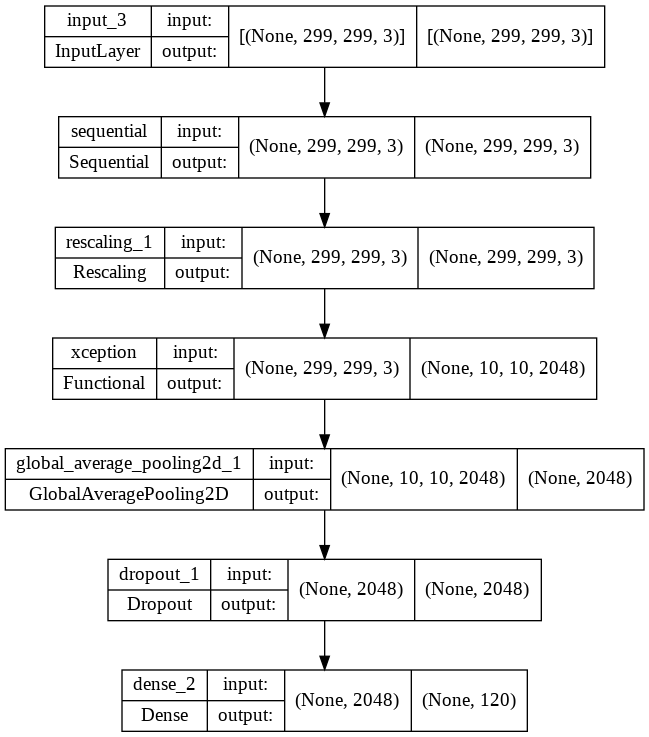

In [19]:
plot_model(model, show_shapes=True, show_layer_names=True, to_file='model_xception.png')

Train top layer

In [20]:
model.compile(
    optimizer=keras.optimizers.Adam(),
    loss=keras.losses.CategoricalCrossentropy(),
    metrics=[keras.metrics.CategoricalAccuracy(), tf.keras.metrics.Precision(), tf.keras.metrics.Recall()],
)

epochs = 25
history = model.fit(train_ds, epochs=epochs, validation_data=test_ds)

Epoch 1/25
375/375 [==============================] - 93s 239ms/step - loss: 1.1566 - categorical_accuracy: 0.7759 - val_loss: 0.3579 - val_categorical_accuracy: 0.9057
Epoch 2/25
375/375 [==============================] - 89s 236ms/step - loss: 0.4352 - categorical_accuracy: 0.8714 - val_loss: 0.3074 - val_categorical_accuracy: 0.9076
Epoch 3/25
375/375 [==============================] - 89s 237ms/step - loss: 0.3654 - categorical_accuracy: 0.8874 - val_loss: 0.2978 - val_categorical_accuracy: 0.9059
Epoch 4/25
375/375 [==============================] - 89s 236ms/step - loss: 0.3311 - categorical_accuracy: 0.8950 - val_loss: 0.2921 - val_categorical_accuracy: 0.9068
Epoch 5/25
375/375 [==============================] - 89s 236ms/step - loss: 0.2929 - categorical_accuracy: 0.9080 - val_loss: 0.2927 - val_categorical_accuracy: 0.9068
Epoch 6/25
375/375 [==============================] - 89s 236ms/step - loss: 0.2807 - categorical_accuracy: 0.9105 - val_loss: 0.2955 - val_categorical_acc

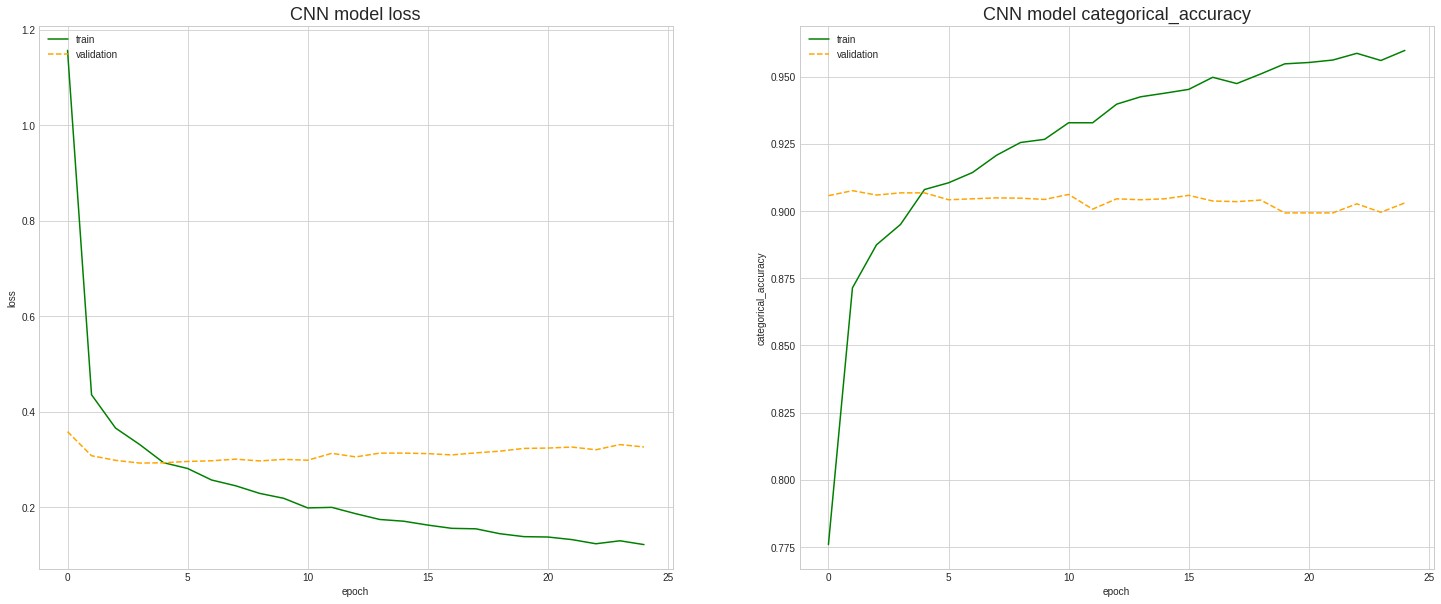

In [21]:
plot_history_scores(history, "loss", "categorical_accuracy")

In [22]:
history.model.save('xception_trained_model.h5')

In [23]:
model = tf.keras.models.load_model('xception_trained_model.h5')

Estimation rapide

In [24]:
for images, labels in test_ds.take(2):
    for i in range(labels.shape[0] -1):
        label_id = np.argmax(labels[i])
        label_name = ds_info.features['label'].names[label_id]
        found_label_id = np.argmax(model(images, training=False)[i], axis=0)
        found_label = ds_info.features['label'].names[found_label_id]
        if (label_id == found_label_id):
            found = 'ok !'
        else:
            found = ':('
        print(f'given: {label_name} --> found: {found_label} -- {found}')


given: n02102177-welsh_springer_spaniel --> found: n02102177-welsh_springer_spaniel -- ok !
given: n02106662-german_shepherd --> found: n02106662-german_shepherd -- ok !
given: n02099712-labrador_retriever --> found: n02099712-labrador_retriever -- ok !
given: n02088466-bloodhound --> found: n02088466-bloodhound -- ok !
given: n02107683-bernese_mountain_dog --> found: n02107683-bernese_mountain_dog -- ok !
given: n02093859-kerry_blue_terrier --> found: n02093859-kerry_blue_terrier -- ok !
given: n02099429-curly-coated_retriever --> found: n02099429-curly-coated_retriever -- ok !
given: n02088094-afghan_hound --> found: n02088094-afghan_hound -- ok !
given: n02102318-cocker_spaniel --> found: n02102318-cocker_spaniel -- ok !
given: n02110185-siberian_husky --> found: n02110185-siberian_husky -- ok !
given: n02088238-basset --> found: n02089867-walker_hound -- :(
given: n02085782-japanese_spaniel --> found: n02085782-japanese_spaniel -- ok !
given: n02100583-vizsla --> found: n02109047-g

Certaines prédictions sont fausses, en regardant des exemples de races, on constate qu'elles sont très proches ce qui peut induire le modèle en erreur.

Le modèle a confondu ces races :

coated_wheaten_terrier avec sealyham_terrier : 
![](https://github.com/vjuge/oc-iml/blob/P6/modules/P6/assets/coated_wheaten_terrier.jpg?raw=1) -- ![](https://github.com/vjuge/oc-iml/blob/P6/modules/P6/assets/sealyham_terrier.jpg?raw=1)

airedale avec lakeland_terrier:
![](https://github.com/vjuge/oc-iml/blob/P6/modules/P6/assets/airedale.jpg?raw=1) -- ![](https://github.com/vjuge/oc-iml/blob/P6/modules/P6/assets/lakeland_terrier.jpg?raw=1)

standard_poodle avec miniature_poodle
![](https://github.com/vjuge/oc-iml/blob/P6/modules/P6/assets/standard_poodle.jpg?raw=1) -- ![](https://github.com/vjuge/oc-iml/blob/P6/modules/P6/assets/miniature_poodle.jpg?raw=1)

norwegian_elkhound avec leonberg
![](https://github.com/vjuge/oc-iml/blob/P6/modules/P6/assets/norwegian_elkhound.jpg?raw=1) -- ![](https://github.com/vjuge/oc-iml/blob/P6/modules/P6/assets/leonberg.jpg?raw=1)

Il pourrait être difficile pour quelqu'un de non avisé de faire la différence.

## APPENDIX & Docs

### Data augmentation:

<https://pyimagesearch.com/2019/07/08/keras-imagedatagenerator-and-data-augmentation/>


### Model compile

What are the choices for optimizer, loss & metrics ? : <https://keras.io/guides/training_with_built_in_methods#many-builtin-optimizers-losses-and-metrics-are-available>

* optimizers: <https://keras.io/api/optimizers/>
* Losses: <https://keras.io/api/losses/>
* Metrics: <https://keras.io/api/metrics/>



tip: in order to view GPU usage, type command: `watch -n 1 nvidia-smi`

### Pre-trained model : Transfer Learning

Kera doc: <https://keras.io/guides/transfer_learning/>

deep learning with Python <https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html>

